### import module

In [1]:
import os
import  pandas as pd
import  numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.impute import KNNImputer

In [2]:
data_path = f"{os.getcwd()}/train.csv"
data = pd.read_csv(data_path)

In [3]:
round(data.describe(), 2)

,D_Dbuild,D_StructureSystem_RC,D_StructureSystem_Precast_Concrete,D_StructureSystem_Steel,D_StructureSystem_Reinfored_Brick,D_StructureSystem_Brick_Wall,D_StructureSystem_Brick_wall_with_Wooden_pillar,D_StructureSystem_Wood_or_Synthetic_Resins,D_StructureSystem_SRC,D_StructureSystem_NaN,...,D_Ra_Capacity,D_Ra_CDR,Total_Height,Total_DeadLoad,Total_LiveLoad,Total_Floor,Avg_Confc,Avg_MBfy,Avg_stify,D_isR
count,3.034000e+03,3034.00,3034.0,3034.00,3034.00,3034.00,3034.0,3034.00,3034.00,3034.00,...,28.00,325.00,3034.00,3.034000e+03,3.034000e+03,3034.00,3034.00,3.034000e+03,3034.00,3334.0
mean,8.378646e+05,3386.47,0.0,-350.24,0.16,-182.52,0.0,0.00,-594.02,1703.38,...,0.23,-4391.49,60.96,3.015481e+10,3.519362e+06,2026.96,179.33,-4.049335e+06,2783.09,0.8
std,2.407838e+07,143140.01,0.0,13187.77,0.36,20211.61,0.0,0.02,12601.32,109533.86,...,0.08,181851.97,250.78,1.381267e+12,1.292785e+08,1993.96,161.56,1.713201e+08,181.76,0.4
min,-2.797630e+08,-1143922.97,0.0,-143080.51,0.00,-184521.52,0.0,0.00,-99768.31,-991140.79,...,0.11,-524599.13,0.00,-1.274041e+13,0.000000e+00,0.00,-193.84,-1.616031e+09,0.00,0.0
25%,1.931000e+03,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.16,-131218.91,7.20,-1.888106e+06,1.779938e+05,819.25,69.50,2.683210e+03,2800.00,1.0
50%,1.984000e+03,1.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.22,0.58,10.80,1.613512e+06,3.685400e+05,1541.00,177.83,2.828620e+03,2800.00,1.0
75%,2.012000e+03,1.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.29,121474.39,14.60,5.230416e+06,6.824250e+05,2658.92,281.74,2.972530e+03,2800.00,1.0
max,2.948692e+08,1353461.29,0.0,104586.42,1.00,193310.45,0.0,1.00,130089.05,1192229.66,...,0.39,427697.09,2270.00,1.594834e+13,7.063128e+09,44740.00,4352.39,1.457750e+09,4200.00,1.0


### Function

In [4]:
# 繪製盒鬚圖

def box(data:pd.DataFrame):
    # 使用melt函數將資料轉換成長格式，以便盒鬚圖的繪製
    data_melted = pd.melt(data, var_name='Variable', value_name='Value')

    # 繪製盒鬚圖
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Variable', y='Value', data=data_melted)
    plt.title('Box Plot of Multiple Variables')
    plt.xlabel('Variables')
    plt.ylabel('Values')
    plt.show()

In [5]:
# 繪製直方圖
def hist(data:pd.DataFrame):
    column_names = data.columns
    num_columns = len(column_names)

    # 計算所需的行列數
    num_rows = num_columns // 4
    if num_columns % 4 != 0:
        num_rows += 1

    # 創建1x3的子圖，每行有3子圖
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))

    # 將axes轉換成一维数组，以便後續迭代操作
    axes = axes.ravel()

    for i, column in enumerate(column_names): # enumerate 函數用來獲取每個元素的索引 i 和對應的 column name
        ax = axes[i]
        if i < num_columns:
            data[column].hist(ax=ax)
            ax.set_xlabel(f'{column}')
            ax.set_ylabel('Count')
            ax.set_title(f'{column} Distribution')
            ax.grid(False)

    # 删除多的子圖
    for i in range(num_columns, num_rows * 4):
        fig.delaxes(axes[i])

    # 自動調整圖形佈局
    plt.tight_layout()

    plt.show()

In [6]:
# 看 dataframe 中 feature 缺失值與比例
def missing_value(data:pd.DataFrame):
    df_missing_value = pd.DataFrame(data.isna().sum(), columns=['missing value'])
    df_missing_value = df_missing_value.sort_values(by='missing value', ascending=False)
    df_missing_value['missing value %'] = round(df_missing_value['missing value']/len(data), 2)
    return df_missing_value

# 看 dataframe 中 feature 眾數跟中位數
def mode_median(data:pd.DataFrame):
    data_median = data.describe()
    data_median = data_median.transpose()
    data_median = pd.DataFrame(data_median['50%'])

    modes = data.mode()
    modes = modes.head(1)
    modes = pd.DataFrame(modes.transpose())
    modes.columns = ['mode']

    merged_df = pd.merge(data_median, modes, left_index=True, right_index=True)
    merged_df = round(merged_df.sort_values(by='50%', ascending=True), 2)
    return merged_df

# round(data_median.sort_values(by='50%', ascending=False), 3)

def make_positive(x):
    return abs(x)


#### 模型

In [21]:
def predict_data_weigthed(X, y):

    # 訓練    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    class_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print(len(y_train[y_train == 0]) ,  len(y_train[y_train == 1]))

    f1_weighted_scorer = make_scorer(f1_score)

    # alpha = 0.35 # 正規化強度

    # model = XGBClassifier(
    #     scale_pos_weight=class_weight,
    #     reg_alpha=alpha,  # L1
    #     reg_lambda=alpha,  # L2
    #     scorer=f1_weighted_scorer,
    # )
    
    model = XGBClassifier(scale_pos_weight=class_weight, scorer=f1_weighted_scorer)
    # model = XGBClassifier(scale_pos_weight=class_weight, scorer=f1_weighted_scorer, average='weighted', learning_rate=0.1, max_depth=6, n_estimators=300,subsample= 0.7)
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    f1 = f1_score(y_valid, y_pred)
    print("F1 Score: {:.4f}".format(f1))   

    f1_weighted = f1_score(y_valid, y_pred, average='weighted')
    print("F1 weighted Score: {:.4f}".format(f1_weighted))    

    # 混淆矩陣
    cm = confusion_matrix(y_valid, y_pred)
    print("Confusion Matrix:")
    print(cm)

    print(classification_report(y_valid,y_pred))

    plt.figure(figsize=(10,5))
    sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='BuPu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()

    
    data_path = f"{os.getcwd()}/X_test.csv"
    X_test = pd.read_csv(data_path)

    # 存擋
    y_pred_test = model.predict(X_test[X_train.columns])
    dic = {
        'id': X_test.index + 1,
        'label': y_pred_test
    }
    y_pred_test = pd.DataFrame(dic)
    y_pred_test.to_csv(f"{os.getcwd()}/y_pred_newest.csv", index=False)
    
    # 看結果
    print('1:', len(y_pred_test[y_pred_test['label']==1]))
    print('0:', len(y_pred_test[y_pred_test['label']==0]))

    return f1
    

### EDA

In [8]:
# 看資料樣貌
data.shape

data_types = data.dtypes
data_types.value_counts()

round(data.describe(), 2)

,D_Dbuild,D_StructureSystem_RC,D_StructureSystem_Precast_Concrete,D_StructureSystem_Steel,D_StructureSystem_Reinfored_Brick,D_StructureSystem_Brick_Wall,D_StructureSystem_Brick_wall_with_Wooden_pillar,D_StructureSystem_Wood_or_Synthetic_Resins,D_StructureSystem_SRC,D_StructureSystem_NaN,...,D_Ra_Capacity,D_Ra_CDR,Total_Height,Total_DeadLoad,Total_LiveLoad,Total_Floor,Avg_Confc,Avg_MBfy,Avg_stify,D_isR
count,3.034000e+03,3034.00,3034.0,3034.00,3034.00,3034.00,3034.0,3034.00,3034.00,3034.00,...,28.00,325.00,3034.00,3.034000e+03,3.034000e+03,3034.00,3034.00,3.034000e+03,3034.00,3334.0
mean,8.378646e+05,3386.47,0.0,-350.24,0.16,-182.52,0.0,0.00,-594.02,1703.38,...,0.23,-4391.49,60.96,3.015481e+10,3.519362e+06,2026.96,179.33,-4.049335e+06,2783.09,0.8
std,2.407838e+07,143140.01,0.0,13187.77,0.36,20211.61,0.0,0.02,12601.32,109533.86,...,0.08,181851.97,250.78,1.381267e+12,1.292785e+08,1993.96,161.56,1.713201e+08,181.76,0.4
min,-2.797630e+08,-1143922.97,0.0,-143080.51,0.00,-184521.52,0.0,0.00,-99768.31,-991140.79,...,0.11,-524599.13,0.00,-1.274041e+13,0.000000e+00,0.00,-193.84,-1.616031e+09,0.00,0.0
25%,1.931000e+03,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.16,-131218.91,7.20,-1.888106e+06,1.779938e+05,819.25,69.50,2.683210e+03,2800.00,1.0
50%,1.984000e+03,1.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.22,0.58,10.80,1.613512e+06,3.685400e+05,1541.00,177.83,2.828620e+03,2800.00,1.0
75%,2.012000e+03,1.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.29,121474.39,14.60,5.230416e+06,6.824250e+05,2658.92,281.74,2.972530e+03,2800.00,1.0
max,2.948692e+08,1353461.29,0.0,104586.42,1.00,193310.45,0.0,1.00,130089.05,1192229.66,...,0.39,427697.09,2270.00,1.594834e+13,7.063128e+09,44740.00,4352.39,1.457750e+09,4200.00,1.0


### 資料前處理

#### 處理缺失值>80% + 全部轉正數 => data_preproc

In [9]:
# 查看缺失值比例
df_missing_value = missing_value(data)

# 去掉缺失值 >80% 的欄位，並且記錄欄位
drop_columns = list(df_missing_value[df_missing_value['missing value %'] > 0.8].index)

#留下缺失值 <80% 的 feature
remain_columns = df_missing_value[df_missing_value['missing value %'] <= 0.8]
remain_columns = list(df_missing_value[df_missing_value['missing value %'] < 0.8].index)
data_dropmissing = data[remain_columns]
data_preproc= data_dropmissing.copy()

#全部轉正數
data_preproc = make_positive(data_preproc)
round(data_preproc.describe(),2)

,D_floorTAGround,D_Demand,D_MaxCl,D_NeutralDepth,D_sd1,D_td0,D_sds,D_patitionwall,D_nonstructure,D_Ty,...,D_1floorCorridorCol,D_1floorCorridorColA,D_1floorClassCol,D_1floorClassColA,D_1floorInsideCol,D_1floorInsideColA,D_X4brickwall,D_X3brickwall,D_YRCwallA,D_isR
count,2103.00,2697.00,2709.00,2713.00,2766.00,2779.00,2802.00,3030.00,3031.00,3.032000e+03,...,3034.00,3.034000e+03,3.034000e+03,3.034000e+03,3.034000e+03,3.034000e+03,3.034000e+03,3034.00,3034.00,3334.0
mean,267.89,5617.68,1680283.11,247471.86,0.61,0.85,12736.48,20297.17,51923.76,5.813668e+06,...,783124.20,2.094326e+09,7.782141e+07,5.492986e+09,2.572888e+07,1.147570e+09,2.789062e+10,78153.19,103241.14,0.8
std,590.16,20332.83,5883219.84,876032.90,0.15,0.26,45993.72,76289.41,200883.52,2.332940e+07,...,2961516.15,8.017991e+09,2.975350e+08,2.174657e+10,1.001315e+08,4.479619e+09,1.051907e+11,1296155.51,186446.97,0.4
min,0.00,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.200000e-01,...,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,1.01,0.0
25%,0.00,0.24,0.04,2.80,0.51,0.69,0.60,1.00,0.00,3.117000e+01,...,0.00,0.000000e+00,1.700000e+01,2.880000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.00,41443.06,1.0
50%,0.00,0.31,0.11,4.20,0.60,0.82,0.77,1.00,1.00,6.288000e+01,...,0.00,0.000000e+00,2.800000e+01,5.177700e+04,2.000000e+00,1.250000e+03,0.000000e+00,0.00,83991.04,1.0
75%,363.15,0.36,0.60,6.00,0.68,0.90,0.90,1.00,1.00,9.344000e+01,...,13.00,2.053725e+04,4.600000e+01,9.195000e+04,8.000000e+00,9.600000e+03,1.968000e+04,21360.00,126543.49,1.0
max,11741.00,178362.52,48615314.63,8027034.76,1.11,1.75,392999.11,746009.80,2048386.53,2.232322e+08,...,29912932.83,7.157522e+10,2.657721e+09,2.225255e+11,1.175632e+09,3.855583e+10,1.068360e+12,70440000.00,3158858.95,1.0


#### 處理離群值

In [10]:
# reset 清理中的數據
spec_features = []

for column in (data_preproc.columns)[:-1]:
    # 當中位數
    median = data_preproc[column].median()
    banchmark = data_preproc[column].quantile(0.7)
    
    if(banchmark<500):
        data_preproc[column] = data_preproc[column].apply(lambda x: None if (x > 3 *banchmark ) else x)
   
    else:
        data_preproc[column] = data_preproc[column].apply(lambda x: None if ((x > 5 * banchmark)|(x < 1/5 * banchmark)) else x)
        
round(data_preproc.describe(), 2)


,D_floorTAGround,D_Demand,D_MaxCl,D_NeutralDepth,D_sd1,D_td0,D_sds,D_patitionwall,D_nonstructure,D_Ty,...,D_1floorCorridorCol,D_1floorCorridorColA,D_1floorClassCol,D_1floorClassColA,D_1floorInsideCol,D_1floorInsideColA,D_X4brickwall,D_X3brickwall,D_YRCwallA,D_isR
count,1825.00,2399.00,2135.00,2413.00,2766.00,2779.00,2501.00,2724.00,2733.0,2740.00,...,2659.00,914.00,2717.00,2378.00,2624.00,1133.00,442.00,752.00,2558.00,3334.0
mean,102.72,0.30,0.14,3.99,0.61,0.85,0.74,1.00,0.7,56.59,...,4.36,22515.42,29.54,64932.59,2.89,9285.92,18998.52,20194.65,98412.92,0.8
std,184.27,0.07,0.19,2.05,0.15,0.26,0.15,0.26,0.7,32.40,...,7.16,16047.78,18.97,46577.97,4.30,7468.96,11202.21,15068.49,50744.65,0.4
min,0.00,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.12,...,0.00,2880.00,0.00,16600.00,0.00,1440.00,3000.00,2400.00,23824.88,0.0
25%,0.00,0.24,0.03,2.60,0.51,0.69,0.60,1.00,0.0,28.26,...,0.00,10000.00,16.00,33600.00,0.00,4000.00,9600.00,8160.00,58624.36,1.0
50%,0.00,0.29,0.07,3.90,0.60,0.82,0.72,1.00,1.0,56.57,...,0.00,18237.50,26.00,52341.70,0.00,6750.00,16296.00,14400.00,95780.88,1.0
75%,142.92,0.33,0.16,5.10,0.68,0.90,0.80,1.00,1.0,84.61,...,7.00,30718.50,39.00,82500.00,5.00,12000.00,27780.00,28851.00,131290.08,1.0
max,688.26,1.00,0.99,14.00,1.11,1.75,1.14,2.00,2.0,112.50,...,30.00,72000.00,122.00,398280.00,18.00,35700.00,46550.00,59796.00,575038.70,1.0


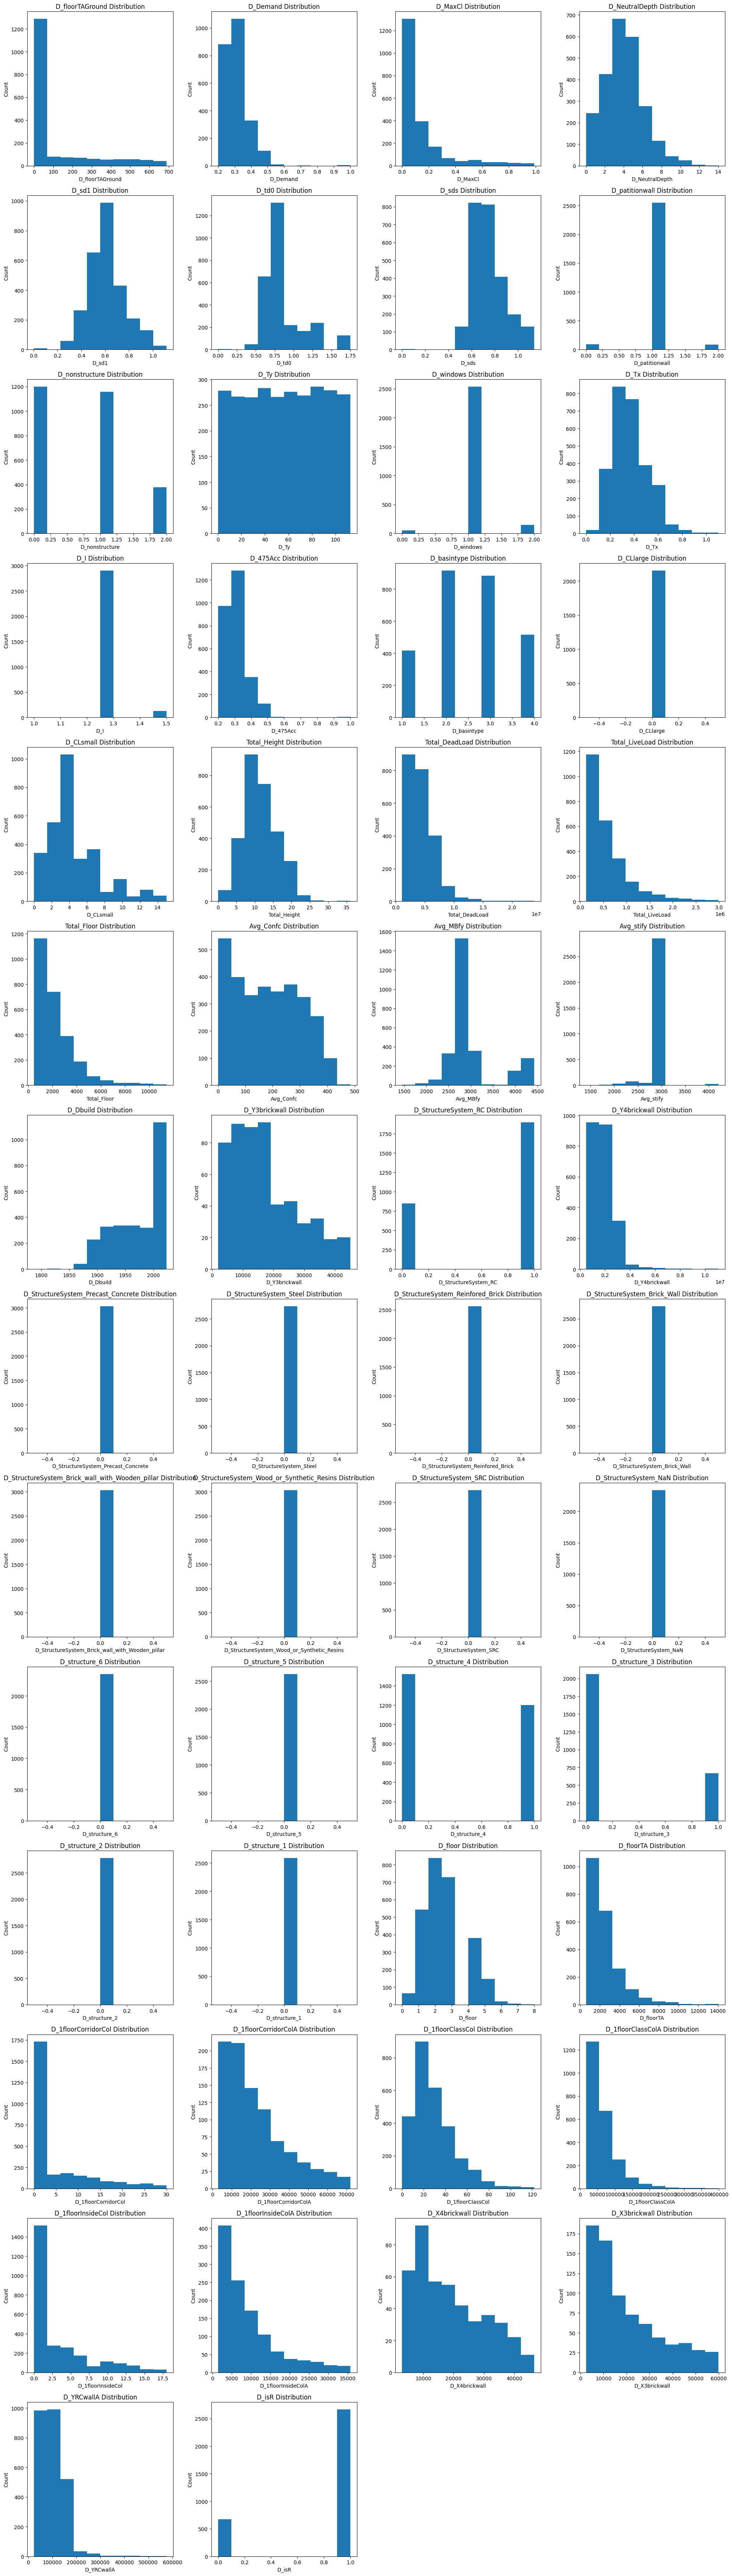

In [11]:
hist(data_preproc)

In [12]:
data_preproc.to_csv('train_preproc_未補缺失.csv', index=False) 

------------

### 確認剩下的缺失值狀態

In [13]:
data_preproc.describe()

,D_floorTAGround,D_Demand,D_MaxCl,D_NeutralDepth,D_sd1,D_td0,D_sds,D_patitionwall,D_nonstructure,D_Ty,...,D_1floorCorridorCol,D_1floorCorridorColA,D_1floorClassCol,D_1floorClassColA,D_1floorInsideCol,D_1floorInsideColA,D_X4brickwall,D_X3brickwall,D_YRCwallA,D_isR
count,1825.000000,2399.00000,2135.000000,2413.000000,2766.000000,2779.000000,2501.000000,2724.000000,2733.000000,2740.000000,...,2659.000000,914.000000,2717.000000,2378.000000,2624.000000,1133.000000,442.000000,752.000000,2558.000000,3334.000000
mean,102.724866,0.30118,0.143232,3.987837,0.610761,0.854469,0.739816,0.998532,0.699232,56.594449,...,4.361790,22515.416160,29.535517,64932.592111,2.885290,9285.921598,18998.520317,20194.651622,98412.918551,0.799040
std,184.274838,0.06769,0.187174,2.051873,0.150347,0.257257,0.148069,0.255670,0.697404,32.398238,...,7.157477,16047.784919,18.972345,46577.973625,4.303775,7468.961125,11202.206894,15068.492546,50744.647915,0.400778
min,0.000000,0.20000,0.000000,0.000000,0.004387,0.000000,0.000000,0.000000,0.000000,0.118237,...,0.000000,2880.000000,0.000000,16600.000000,0.000000,1440.000000,3000.000000,2400.000000,23824.879397,0.000000
25%,0.000000,0.24000,0.030000,2.600000,0.507318,0.690000,0.600000,1.000000,0.000000,28.259705,...,0.000000,10000.000000,16.000000,33600.000000,0.000000,4000.000000,9600.000000,8160.000000,58624.357339,1.000000
50%,0.000000,0.29000,0.070000,3.900000,0.604515,0.820000,0.720000,1.000000,1.000000,56.573111,...,0.000000,18237.500000,26.000000,52341.700000,0.000000,6750.000000,16296.000000,14400.000000,95780.880315,1.000000
75%,142.920000,0.33000,0.160000,5.100000,0.683630,0.900000,0.800000,1.000000,1.000000,84.614467,...,7.000000,30718.500000,39.000000,82500.000000,5.000000,12000.000000,27780.000000,28851.000000,131290.084612,1.000000
max,688.260000,1.00000,0.990000,14.000000,1.111742,1.750000,1.140000,2.000000,2.000000,112.495163,...,30.000000,72000.000000,122.000000,398280.000000,18.000000,35700.000000,46550.000000,59796.000000,575038.695303,1.000000


In [14]:
missing_ori = data.isna().sum().sum()
missing_preproc = data_preproc.isna().sum().sum()

print(f"原始缺失值總數：{missing_ori}")
print(f"前處理中缺失值總數：{missing_preproc}")

原始缺失值總數：34220
前處理中缺失值總數：46075


In [15]:
data_preproc.describe()

,D_floorTAGround,D_Demand,D_MaxCl,D_NeutralDepth,D_sd1,D_td0,D_sds,D_patitionwall,D_nonstructure,D_Ty,...,D_1floorCorridorCol,D_1floorCorridorColA,D_1floorClassCol,D_1floorClassColA,D_1floorInsideCol,D_1floorInsideColA,D_X4brickwall,D_X3brickwall,D_YRCwallA,D_isR
count,1825.000000,2399.00000,2135.000000,2413.000000,2766.000000,2779.000000,2501.000000,2724.000000,2733.000000,2740.000000,...,2659.000000,914.000000,2717.000000,2378.000000,2624.000000,1133.000000,442.000000,752.000000,2558.000000,3334.000000
mean,102.724866,0.30118,0.143232,3.987837,0.610761,0.854469,0.739816,0.998532,0.699232,56.594449,...,4.361790,22515.416160,29.535517,64932.592111,2.885290,9285.921598,18998.520317,20194.651622,98412.918551,0.799040
std,184.274838,0.06769,0.187174,2.051873,0.150347,0.257257,0.148069,0.255670,0.697404,32.398238,...,7.157477,16047.784919,18.972345,46577.973625,4.303775,7468.961125,11202.206894,15068.492546,50744.647915,0.400778
min,0.000000,0.20000,0.000000,0.000000,0.004387,0.000000,0.000000,0.000000,0.000000,0.118237,...,0.000000,2880.000000,0.000000,16600.000000,0.000000,1440.000000,3000.000000,2400.000000,23824.879397,0.000000
25%,0.000000,0.24000,0.030000,2.600000,0.507318,0.690000,0.600000,1.000000,0.000000,28.259705,...,0.000000,10000.000000,16.000000,33600.000000,0.000000,4000.000000,9600.000000,8160.000000,58624.357339,1.000000
50%,0.000000,0.29000,0.070000,3.900000,0.604515,0.820000,0.720000,1.000000,1.000000,56.573111,...,0.000000,18237.500000,26.000000,52341.700000,0.000000,6750.000000,16296.000000,14400.000000,95780.880315,1.000000
75%,142.920000,0.33000,0.160000,5.100000,0.683630,0.900000,0.800000,1.000000,1.000000,84.614467,...,7.000000,30718.500000,39.000000,82500.000000,5.000000,12000.000000,27780.000000,28851.000000,131290.084612,1.000000
max,688.260000,1.00000,0.990000,14.000000,1.111742,1.750000,1.140000,2.000000,2.000000,112.495163,...,30.000000,72000.000000,122.000000,398280.000000,18.000000,35700.000000,46550.000000,59796.000000,575038.695303,1.000000


#### 填補缺失值

In [16]:

data_clear = data_preproc.copy()

data_clear = pd.DataFrame(data)

medians = data_clear.median()

data_clear = data_clear.fillna(medians)

data_clear.describe()

,D_Dbuild,D_StructureSystem_RC,D_StructureSystem_Precast_Concrete,D_StructureSystem_Steel,D_StructureSystem_Reinfored_Brick,D_StructureSystem_Brick_Wall,D_StructureSystem_Brick_wall_with_Wooden_pillar,D_StructureSystem_Wood_or_Synthetic_Resins,D_StructureSystem_SRC,D_StructureSystem_NaN,...,D_Ra_Capacity,D_Ra_CDR,Total_Height,Total_DeadLoad,Total_LiveLoad,Total_Floor,Avg_Confc,Avg_MBfy,Avg_stify,D_isR
count,3.334000e+03,3.334000e+03,3334.0,3334.000000,3334.000000,3334.000000,3334.0,3334.000000,3334.000000,3.334000e+03,...,3334.000000,3334.000000,3334.000000,3.334000e+03,3.334000e+03,3334.000000,3334.000000,3.334000e+03,3334.000000,3334.000000
mean,7.626503e+05,3.081837e+03,0.0,-318.720634,0.141272,-166.092035,0.0,0.000300,-540.573294,1.550104e+03,...,0.225039,-427.560769,56.449403,2.744157e+10,3.235844e+06,1983.230774,179.197070,-3.684713e+06,2784.609406,0.799040
std,2.297044e+07,1.365496e+05,0.0,12580.667776,0.348354,19280.622660,0.0,0.017319,12022.032991,1.044893e+05,...,0.007524,56713.636547,239.656367,1.317667e+12,1.233265e+08,1907.181533,154.121162,1.634323e+08,173.450571,0.400778
min,-2.797630e+08,-1.143923e+06,0.0,-143080.510670,0.000000,-184521.515888,0.0,0.000000,-99768.309199,-9.911408e+05,...,0.110000,-524599.130729,0.000000,-1.274041e+13,0.000000e+00,0.000000,-193.841576,-1.616031e+09,0.000000,0.000000
25%,1.936000e+03,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,...,0.225000,0.580000,7.200000,-1.565645e+06,1.924128e+05,891.917500,80.696207,2.698574e+03,2800.000000,1.000000
50%,1.984000e+03,1.000000e+00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,...,0.225000,0.580000,10.800000,1.613512e+06,3.685400e+05,1541.000000,177.829249,2.828618e+03,2800.000000,1.000000
75%,2.010000e+03,1.000000e+00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,...,0.225000,0.580000,14.400000,4.874800e+06,6.425578e+05,2485.350000,273.046018,2.958791e+03,2800.000000,1.000000
max,2.948692e+08,1.353461e+06,0.0,104586.417793,1.000000,193310.448552,0.0,1.000000,130089.048603,1.192230e+06,...,0.390000,427697.094889,2270.000000,1.594834e+13,7.063128e+09,44740.000000,4352.392633,1.457750e+09,4200.000000,1.000000


### 預測

#### 確認 training data 結果 0/1 比例

In [17]:
data['D_isR'].value_counts()

1    2664
0     670
Name: D_isR, dtype: int64

#### data weigthed 預測

537 2130
F1 Score: 0.8753
F1 weighted Score: 0.7617
Confusion Matrix:
[[ 31 102]
 [ 39 495]]
              precision    recall  f1-score   support

           0       0.44      0.23      0.31       133
           1       0.83      0.93      0.88       534

    accuracy                           0.79       667
   macro avg       0.64      0.58      0.59       667
weighted avg       0.75      0.79      0.76       667



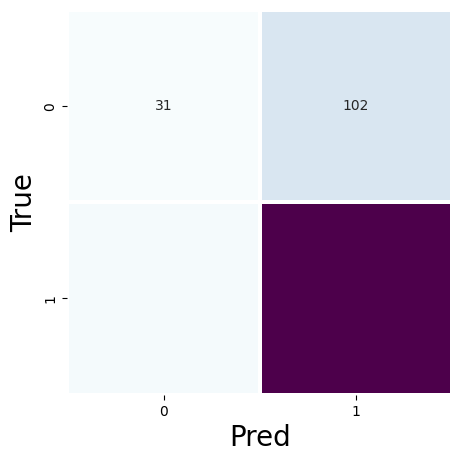

1: 858
0: 408


0.8753315649867375

In [22]:
X = data.iloc[:, :58]
y = data.iloc[:, -1]

predict_data_weigthed(X, y)

#### 未採納的方法

#### 以 KNNImputer 填缺失值並訓練模型（效果不好）

In [ ]:
# KNNImputer

X = data.iloc[:, :58]
y = data.iloc[:, -1]

col = list(X.columns)
imputer = KNNImputer(n_neighbors=7) 
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=col)
predict_data_weigthed(X_imputed, y)

537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:43:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8724
F1 weighted Score: 0.7640
1: 970
0: 296


0.872435325602141

In [ ]:
X = data_preproc.iloc[:, :-1]
y = data_preproc.iloc[:, -1]

col = list(X.columns)
imputer = KNNImputer(n_neighbors=7) 
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=col)
predict_data_weigthed(X_imputed, y)

537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8825
F1 weighted Score: 0.7682
1: 1121
0: 145


0.8824561403508772

#### 用 SMOTE 平衡 traning data

In [ ]:
from imblearn.combine import SMOTEENN

sampling_strategy = {0: 4000, 1: 2664}
sme = SMOTEENN(random_state=42, sampling_strategy=sampling_strategy)

X = data.iloc[:, :58]
X = X.fillna(0)
# y = data.iloc[:, -1]
# X.isna().sum().sum()

X_resampled, y_resampled = sme.fit_resample(X, y)
print('X = ', len(X_resampled))
print('y = ', len(y_resampled))

X_resampled = pd.DataFrame(X_resampled)
X_resampled.isna()
predict_data_weigthed(X_resampled, y_resampled)


/Users/sylvia/anaconda3/lib/python3.11/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (4000) in class 0 will be larger than the number of samples in the majority class (class #1 -> 2664)
  warnings.warn(
/Users/sylvia/anaconda3/lib/python3.11/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (4000) in class 0 will be larger than the number of samples in the majority class (class #1 -> 2664)
  warnings.warn(
/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:42:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


X =  3172
y =  3172
1985 552
F1 Score: 0.7658
F1 weighted Score: 0.9033
1: 814
0: 452


0.7657992565055761

#### 特徵篩選

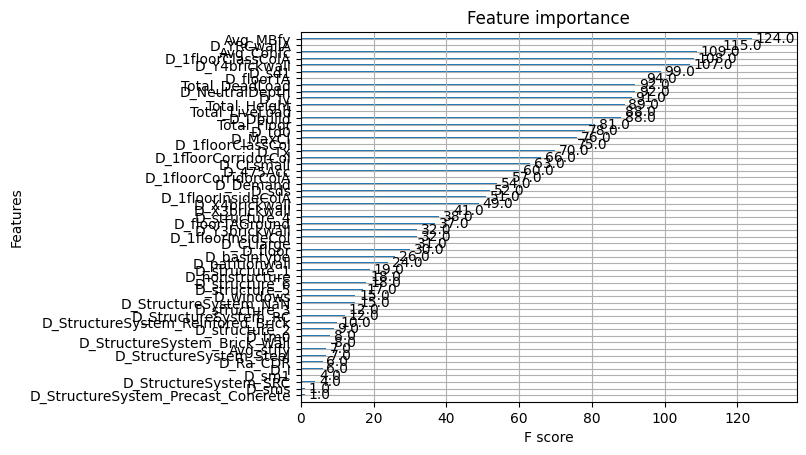

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Assuming you've already imported train_test_split, make_scorer, and f1_score

X = data.iloc[:, :58]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a custom scorer for weighted F1 score
f1_weighted_scorer = make_scorer(f1_score, average='weighted')

# Specify the objective as binary:logistic for binary classification
model = XGBClassifier(objective='binary:logistic', random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Visualize feature importance
xgb.plot_importance(model)
plt.show()


In [ ]:
# 獲取 booster 對象
booster = model.get_booster()

# 使用 get_score() 方法獲取特徵重要性
feature_importance = booster.get_score(importance_type='weight')
sorted_feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

# 將特徵名稱存儲在列表中
feature_names = list(sorted_feature_importance.keys())
len(feature_names)

55

537 2130
F1 Score: 0.6726
F1 weighted Score: 0.6006
1: 991
0: 275
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.7574
F1 weighted Score: 0.6692
1: 973
0: 293
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.7852
F1 weighted Score: 0.6836
1: 264
0: 1002
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8064
F1 weighted Score: 0.6929
1: 577
0: 689
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8149
F1 weighted Score: 0.6986
1: 611
0: 655
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8377
F1 weighted Score: 0.7156
1: 644
0: 622
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8362
F1 weighted Score: 0.7208
1: 650
0: 616
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8368
F1 weighted Score: 0.7188
1: 727
0: 539
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8395
F1 weighted Score: 0.7187
1: 673
0: 593
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8398
F1 weighted Score: 0.7176
1: 593
0: 673
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8384
F1 weighted Score: 0.7075
1: 576
0: 690
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8417
F1 weighted Score: 0.7152
1: 579
0: 687
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8435
F1 weighted Score: 0.7184
1: 670
0: 596
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8556
F1 weighted Score: 0.7378
1: 799
0: 467
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8648
F1 weighted Score: 0.7530
1: 792
0: 474
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8574
F1 weighted Score: 0.7411
1: 846
0: 420
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8597
F1 weighted Score: 0.7421
1: 835
0: 431
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8556
F1 weighted Score: 0.7378
1: 812
0: 454
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8617
F1 weighted Score: 0.7442
1: 802
0: 464
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8680
F1 weighted Score: 0.7494
1: 793
0: 473
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8728
F1 weighted Score: 0.7560
1: 797
0: 469
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8713
F1 weighted Score: 0.7514
1: 858
0: 408
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8668
F1 weighted Score: 0.7495
1: 785
0: 481
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8655
F1 weighted Score: 0.7437
1: 859
0: 407
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8584
F1 weighted Score: 0.7364
1: 797
0: 469
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8713
F1 weighted Score: 0.7573
1: 796
0: 470
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8667
F1 weighted Score: 0.7435
1: 796
0: 470
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8716
F1 weighted Score: 0.7561
1: 813
0: 453
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8670
F1 weighted Score: 0.7483
1: 797
0: 469
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8723
F1 weighted Score: 0.7584
1: 818
0: 448
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8708
F1 weighted Score: 0.7539
1: 786
0: 480
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8632
F1 weighted Score: 0.7367
1: 836
0: 430
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8710
F1 weighted Score: 0.7526
1: 843
0: 423
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8730
F1 weighted Score: 0.7548
1: 834
0: 432
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8740
F1 weighted Score: 0.7558
1: 853
0: 413
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8697
F1 weighted Score: 0.7466
1: 844
0: 422
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8760
F1 weighted Score: 0.7580
1: 817
0: 449
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8762
F1 weighted Score: 0.7567
1: 855
0: 411
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8763
F1 weighted Score: 0.7628
1: 861
0: 405
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8802
F1 weighted Score: 0.7741
1: 870
0: 396
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8715
F1 weighted Score: 0.7501
1: 842
0: 424
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8754
F1 weighted Score: 0.7543
1: 814
0: 452
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8687
F1 weighted Score: 0.7456
1: 830
0: 436
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8740
F1 weighted Score: 0.7558
1: 854
0: 412
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8803
F1 weighted Score: 0.7672
1: 839
0: 427
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8705
F1 weighted Score: 0.7490
1: 841
0: 425
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8732
F1 weighted Score: 0.7535
1: 843
0: 423
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8731
F1 weighted Score: 0.7471
1: 811
0: 455
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8776
F1 weighted Score: 0.7551
1: 830
0: 436
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8690
F1 weighted Score: 0.7505
1: 810
0: 456
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8789
F1 weighted Score: 0.7612
1: 789
0: 477
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8690
F1 weighted Score: 0.7443
1: 871
0: 395
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8844
F1 weighted Score: 0.7704
1: 802
0: 464
537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8772
F1 weighted Score: 0.7578
1: 844
0: 422


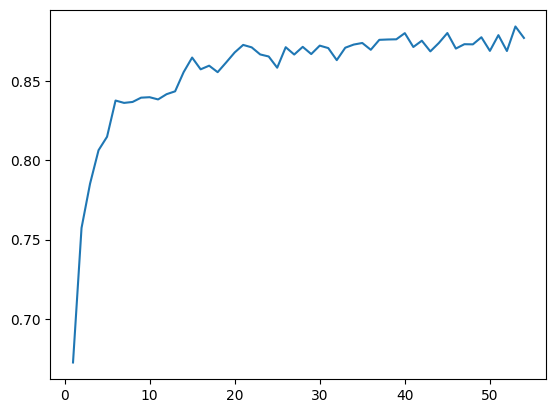

In [ ]:
f1_score_list = []
for i in range(1, len(feature_names)):
    
    X = data[feature_names[:i]]
    y = data.iloc[:, -1]

    f1_return = predict_data_weigthed(X, y)
    f1_score_list.append(f1_return)

x_ax = list(range(1, len(feature_names)))
y_ax = f1_score_list

plt.plot(x_ax, y_ax)
plt.show()

#### 看 Feature 共線性

/Users/sylvia/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


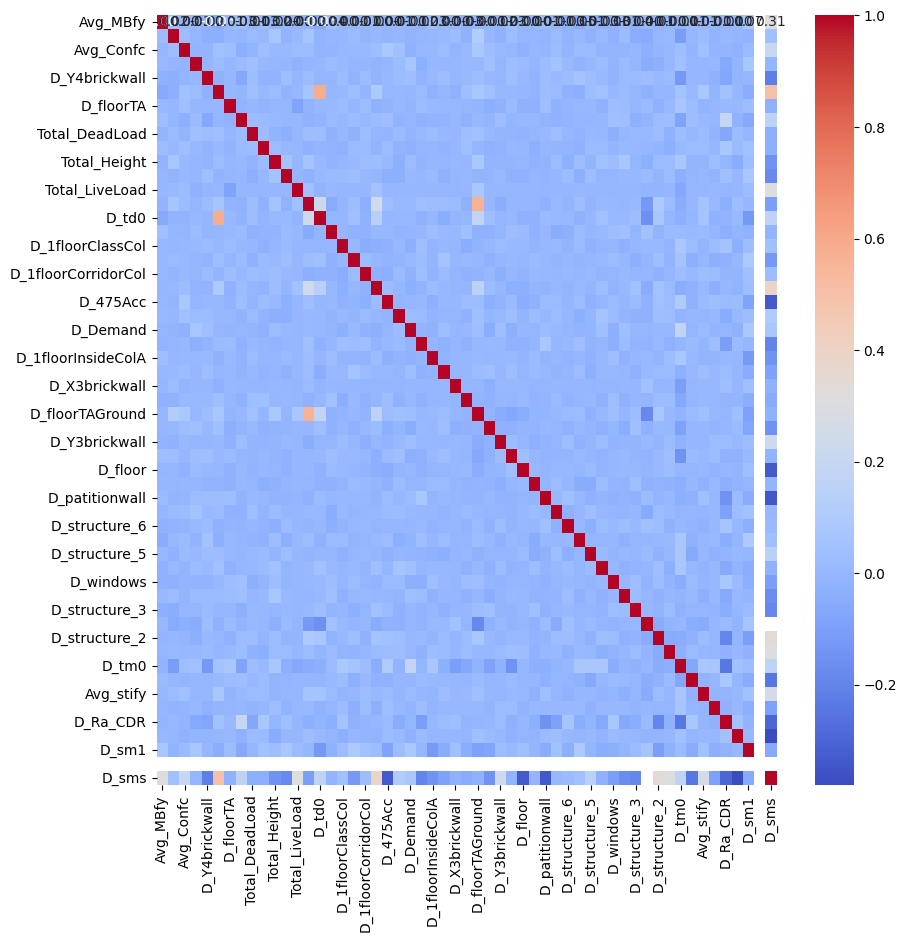

In [ ]:
correlation_matrix = data[feature_names].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [ ]:
import pandas as pd

threshold = 0.4

colinear_features = pd.DataFrame(columns=['Feature1', 'Feature2', 'Correlation'])

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colinear_features = pd.concat([colinear_features, pd.DataFrame({'Feature1': [correlation_matrix.columns[i]],
                                                                           'Feature2': [correlation_matrix.columns[j]],
                                                                           'Correlation': [correlation_matrix.iloc[i, j]]})])
colinear_features.sort_values(by=['Feature1','Feature2'])


,Feature1,Feature2,Correlation
0,D_sd1,D_sms,0.502074
0,D_sd1,D_td0,0.587273
0,Total_Floor,D_floorTAGround,0.568058


#### 去除共線性後預測

In [ ]:
feature_names_filtered = feature_names.copy()
feature_names_filtered = [column for column in feature_names_filtered if column not in ['D_sms', 'D_td0', 'D_floorTAGround']]

X = data[feature_names_filtered].iloc[:, :58]
y = data.iloc[:, -1]

predict_data_weigthed(X, y)

537 2130


/Users/sylvia/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:47:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.8750
F1 weighted Score: 0.7569
1: 805
0: 461


0.8750000000000001

### 最佳化參數

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

X = data.iloc[:, 0:-1]
y = data.iloc[:, -1]

# 創建 XGBoost 分類器

class_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(len(y_train[y_train == 0]) ,  len(y_train[y_train == 1]))

f1_scorer = make_scorer(f1_score)
f1_weighted_scorer = make_scorer(f1_score, average='weighted')

model = XGBClassifier(scale_pos_weight=class_weight, scorer=f1_weighted_scorer)



# 定義加權的 F1 分數評估器
f1_weighted_scorer = make_scorer(f1_score, average='weighted')

# 定義要搜索的超參數範圍
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 9],
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'subsample': [0.5, 0.7, 1.0]
}


# 使用 GridSearchCV 來搜索最佳超參數組合
grid_search = GridSearchCV(model, param_grid, scoring=f1_weighted_scorer, cv=10)
grid_search.fit(X, y)

# 打印最佳超參數組合和對應的加權 F1 分數
print("Best Parameters:", grid_search.best_params_)
print("Best Weighted F1 Score:", grid_search.best_score_)

results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print("Parameters: ", params, "Weighted F1 Score: ", mean_score)


### data balanced

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

X = data.iloc[:, 0:-1].fillna(0)
y = data.iloc[:, -1]

# 使用SMOTE進行過採樣
sampling_strategy = {0: 670*3, 1: 2130} 
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 計算過採樣後的類別權重
class_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

model = XGBClassifier(scale_pos_weight=class_weight)
model.fit(X_train_resampled, y_train_resampled)




In [ ]:
# 預測
data_path = f"{os.getcwd()}/X_test.csv"
X_test = pd.read_csv(data_path)

# 存擋
y_pred_test = model.predict(X_test[X_train.columns])
dic = {
    'id': X_test.index + 1,
    'label': y_pred_test
}
y_pred_test = pd.DataFrame(dic)
y_pred_test.to_csv(f"{os.getcwd()}/y_pred_newest.csv", index=False)

# 看結果
print('1:', len(y_pred_test[y_pred_test['label']==1]))
print('0:', len(y_pred_test[y_pred_test['label']==0]))